<a href="https://colab.research.google.com/github/doukansurel/Machine-Learning-worksheet/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

# Image classification

## Setup

Import TensorFlow and other necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 6s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg'))) # dosya yolu jpg ile bitenlerin liste uzunluğu
print(image_count)

3670


Here are some roses:

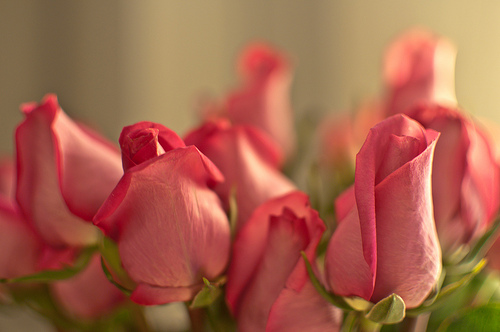

In [ ]:
roses = list(data_dir.glob('roses/*'))    # roses sınıfına ait bir örnek veri
PIL.Image.open(str(roses[0]))

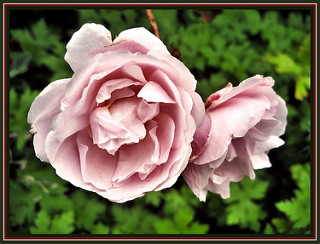

In [ ]:
PIL.Image.open(str(roses[1]))

And some tulips:

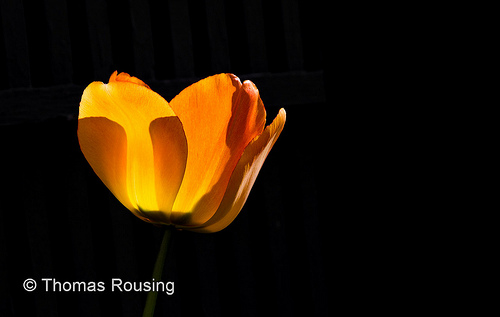

In [ ]:
tulips = list(data_dir.glob('tulips/*'))  #lale sınıfına ait bir veri
PIL.Image.open(str(tulips[0]))

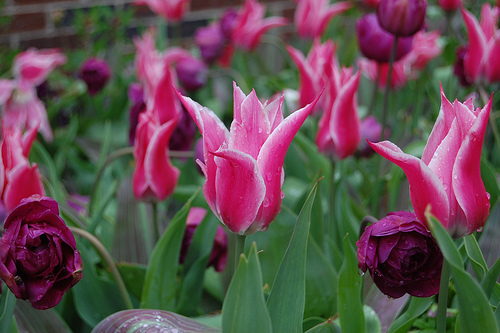

In [ ]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, #cross validation farklı örnekleri kullanma
  subset="training", #alt küme değerini training olarak ayarlama
  seed=123, #rastgele sayı üretimindeki tekrarlanabilirliği sağlamak için kullanılır.
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names  #dizi içerisinde bulunan classlar
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

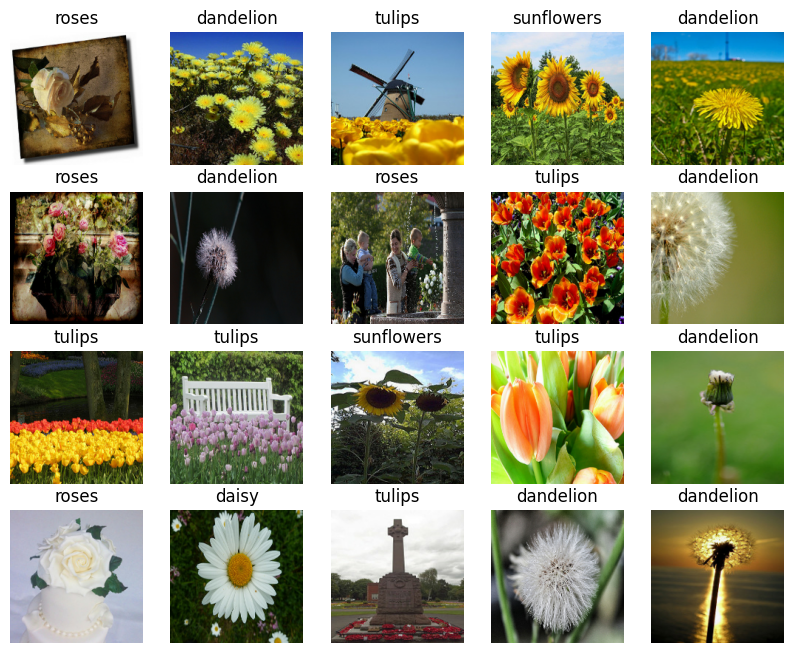

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)   #32 bacth size , 180*180*180 ise boyut
  print(labels_batch.shape)   #32 bacth size
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)   #cache bellekte tutar darboğazı engeller #prefect çakışmayı önler
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)   # rgb degerleri 0 ila 1 arasında tutar

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9961222


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",               #görüntüleri rastgele çeviren ön işleme katmanı
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

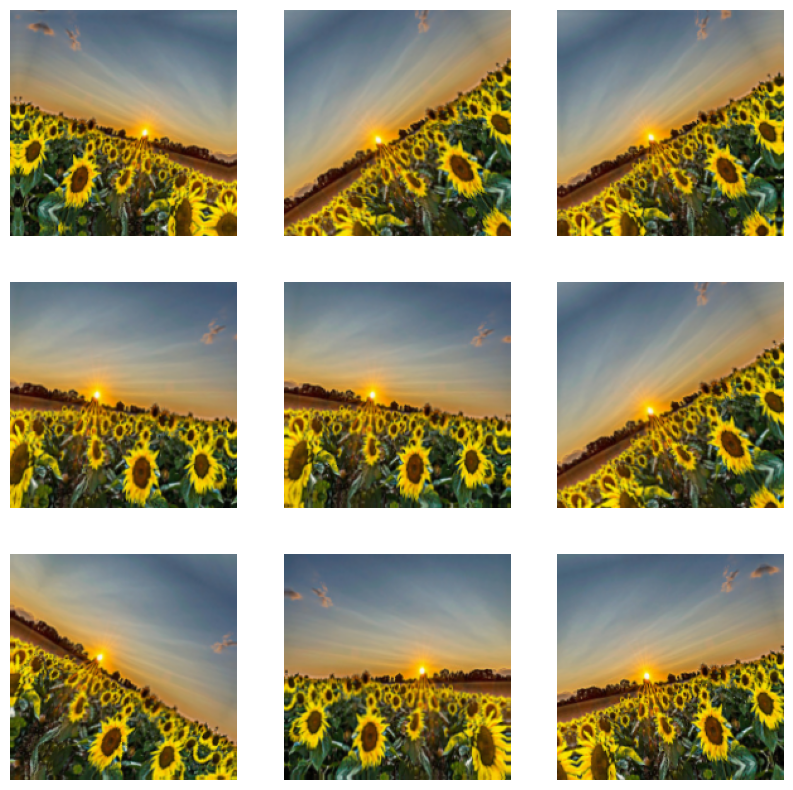

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = 5
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),# işlem sırasında veri boyutunu korumak için same kullanılır.
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation="softmax")
])

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), #modelin daha yavaş ve daha optimize olarak öğrenmesini sağlar
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 18s 49ms/step - loss: 1.4421 - accuracy: 0.3467 - val_loss: 1.2730 - val_accuracy: 0.4373
Epoch 2/15
92/92 [==============================] - 3s 34ms/step - loss: 1.1936 - accuracy: 0.4911 - val_loss: 1.1168 - val_accuracy: 0.5177
Epoch 3/15
92/92 [==============================] - 3s 33ms/step - loss: 1.1171 - accuracy: 0.5426 - val_loss: 1.0677 - val_accuracy: 0.5586
Epoch 4/15
92/92 [==============================] - 3s 37ms/step - loss: 1.0607 - accuracy: 0.5705 - val_loss: 1.0487 - val_accuracy: 0.5695
Epoch 5/15
92/92 [==============================] - 3s 31ms/step - loss: 1.0106 - accuracy: 0.6076 - val_loss: 1.0156 - val_accuracy: 0.5886
Epoch 6/15
92/92 [==============================] - 3s 34ms/step - loss: 0.9875 - accuracy: 0.6134 - val_loss: 1.0695 - val_accuracy: 0.5899
Epoch 7/15
92/92 [==============================] - 3s 33ms/step - loss: 0.9755 - accuracy: 0.6161 - val_loss: 0.9942 - val_accuracy: 0.6117
Epoch 8/15
92/92 [=====

## Compile and train the model

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

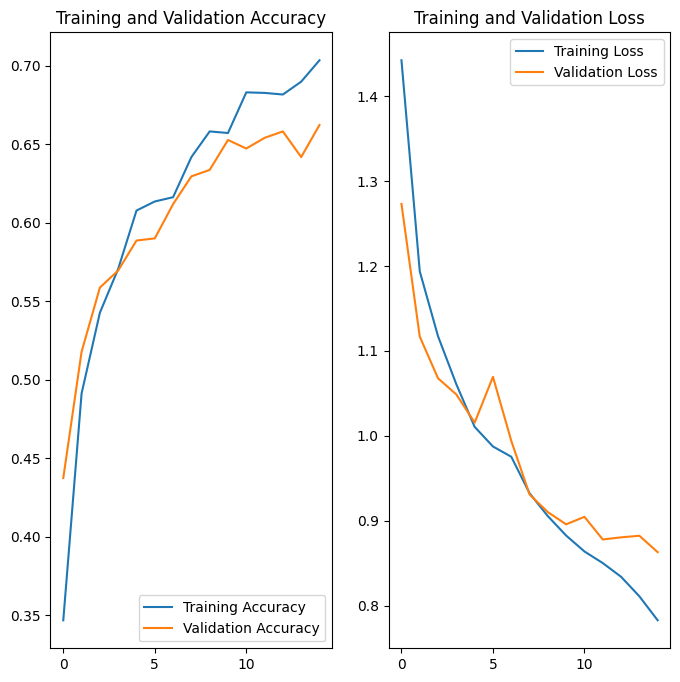

In [ ]:
acc = history.history['accuracy'] #her bir epochta elde edilen metrikler için kullanılır.
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
#Predictions
prediction_probabilities = []
predictions= model.predict(train_ds)
predictions
# test_images üzerinde tahmin yapın
predicted_labels = [class_names[np.argmax(pred)] for pred in predictions]  # En yüksek olasılığa sahip sınıfın ismini al

# Model doğruluk değerini hesaplama
accuracy = model.evaluate(train_ds)[1]

92/92 [==============================] - 1s 12ms/step - loss: 0.7701 - accuracy: 0.7149


In [ ]:
for i in predictions:
  print(i)
  prediction_probabilities.append(i[np.argmax(i)])


In [ ]:
prediction_probabilities[0]

0.9947444

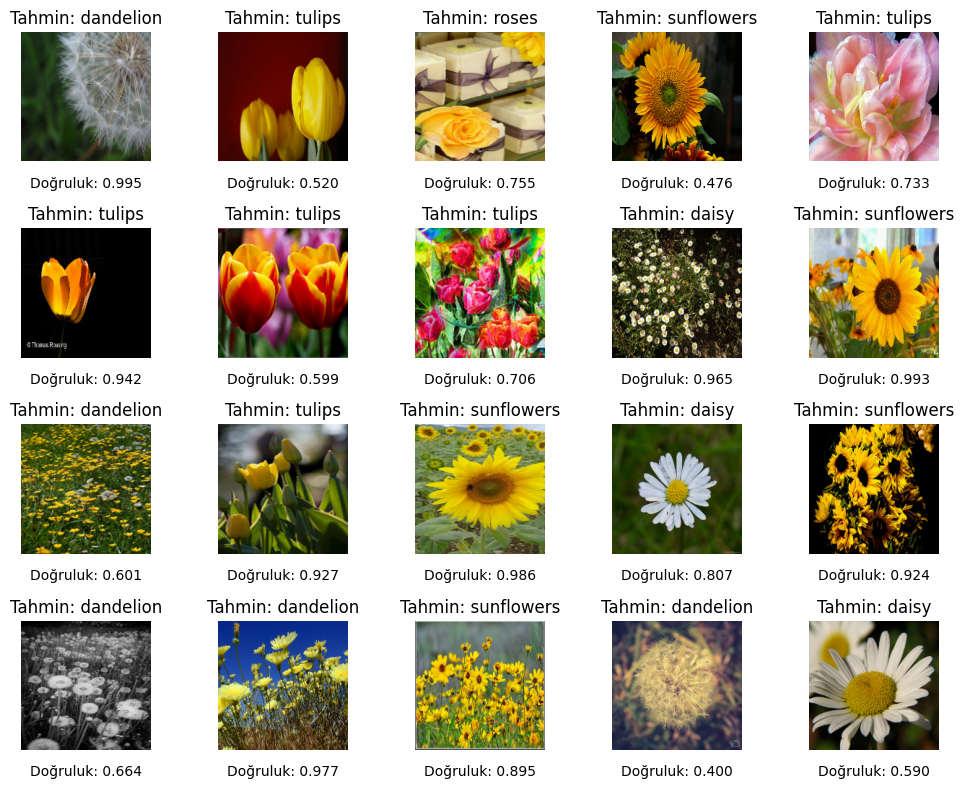

In [ ]:
num_predictions = 20
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
#plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = axes[i // 5, i % 5]
    ax.imshow(images[i].numpy().astype("uint8"), cmap='gray')  # Tahmin etmek istediğimiz görüntülerin olduğu test_images
    ax.set_title(f'Tahmin: {class_names[labels[i]]}')  # Tahmin edilen etiketin ismini başlık olarak ayarlama
    ax.axis('off')

    # Tahmin sonucunu ve doğruluk değerini fotoğrafın üstünde gösterme
    ax.text(0.5, -0.2, f'Doğruluk: {prediction_probabilities[i]:.3f}', transform=ax.transAxes, ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch #genişletme işlemi yapar

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step
This image most likely belongs to sunflowers with a 28.21 percent confidence.


In [ ]:

url ="https://www.ilav.org/wp-content/uploads/2022/11/laleler-4.jpg"

flower_path = tf.keras.utils.get_file('tulips', origin=url)

img = tf.keras.utils.load_img(
    flower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch #genişletme işlemi yapar

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score) )
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to tulips with a 35.79 percent confidence.


In [ ]:
url ="https://img.freepik.com/free-photo/top-view-roses-flowers_23-2148860041.jpg?size=626&ext=jpg"

flower_path = tf.keras.utils.get_file('roses', origin=url)

img = tf.keras.utils.load_img(
    flower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch #genişletme işlemi yapar

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score) )
)

1/1 [==============================] - 0s 109ms/step
This image most likely belongs to roses with a 34.01 percent confidence.


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)   #tensorflow modelinin optimize edilmiş haline getirir
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['rescaling_9_input'], 'outputs': ['dense_15']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite